# Import packages and get authenticated

In [1]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 500)
from tqdm import tqdm_notebook as tqdm
from IPython.display import display
import os
import sys
sys.path.append('/content/drive/My Drive/中研院/repo/')

from utilities import *
from models import *
from dataset_util import *

import time
import datetime
from datetime import datetime
import json

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc( 'savefig', facecolor = 'white' )

from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# def data_saver(data, name, outputdir):
#     """ usage: data_saver(df_merged_interp_alldicts, 'data', outputdir)"""
#     outputdir_data = os.path.join(outputdir, name+'.npz')
#     print('outputdir for {}:'.format(name), outputdir_data)
#     np.savez(outputdir_data, data=data, allow_pickle=True)
#     loaded_data = np.load(outputdir_data, allow_pickle=True)['data']
# #     loaded_data = np.load(outputdir_data, allow_pickle=True)['data']
#     print('Are {} save and loadded correctly? '.format(name), np.array_equal(loaded_data, data))
#     print('')
    
# def data_loader(name, inputdir):
#     """ usage: data = data_loader('data', outputdir)"""
#     inputdir_data = os.path.join(inputdir, name+'.npz')
#     data = np.load(inputdir_data, allow_pickle=True)['data']
#     return data

In [0]:
# class FallDataset(Dataset):
#   def __init__(self, data, labels):
#       self.data = torch.FloatTensor(data)
#       self.labels = torch.FloatTensor(labels)
#       # self.data = torch.LongTensor(data)
#       # self.labels = torch.LongTensor(labels)

#   def __getitem__(self, index):
#       x = self.data[index,:,:]
#       y = self.labels[index]
#       return x, y

#   def __len__(self):
#       return len(self.data)

In [0]:
# # Convolutional neural network (two convolutional layers)
# class ConvNet2(nn.Module):
#     def __init__(self, class_N=2, channel_n=16, input_dim=10, p=0.5):
#         super(ConvNet2, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv1d(3, channel_n, kernel_size=3, stride=1, padding=2),
#             nn.BatchNorm1d(channel_n),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2))
#         self.layer2 = nn.Sequential(
#             nn.Conv1d(channel_n, channel_n, kernel_size=3, stride=1, padding=2),
#             nn.BatchNorm1d(channel_n),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2))
#         # self.layer3 = nn.Sequential(
#         #     nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=2),
#         #     nn.BatchNorm1d(64),
#         #     nn.ReLU(),
#         #     nn.MaxPool1d(kernel_size=2, stride=2))
        
#         cnn_layer1_dim = (input_dim+2*2-1*(3-1)-1)+1
#         pool_layer1_dim = (cnn_layer1_dim-1*(2-1)-1)/2+1

#         # cnn_layer2_dim = (pool_layer1_dim+2*2-1*(3-1)-1)+1
#         # pool_layer2_dim = (cnn_layer2_dim-1*(2-1)-1)/2+1

#         # cnn_layer3_dim = (pool_layer2_dim+2*2-1*(3-1)-1)+1
#         # pool_layer3_dim = (cnn_layer3_dim-1*(2-1)-1)/2+1

#         # print('cnn_layer1_dim:', cnn_layer1_dim)
#         # print('pool_layer1_dim:', pool_layer1_dim)
#         # print('cnn_layer2_dim:', cnn_layer2_dim)
#         # print('pool_layer2_dim:', pool_layer2_dim)
#         # print('cnn_layer3_dim:', cnn_layer3_dim)
#         # print('pool_layer3_dim:', pool_layer3_dim)
#         # fc_dim = int(((((input_dim)+2*2-1)/2+2*2-1)/2+2*2-1)/2*64)
#         self.fc1 = nn.Linear(int(pool_layer1_dim)*channel_n, 50)
#         self.drop_out = nn.Dropout(p=0)
#         self.fc2 = nn.Linear(50, class_N)
        
#     def forward(self, x):
#       out1 = self.layer1(x.float())
#       # print('out1 size:', out1.size())
#       # out2 = self.layer2(out1)
#       # print('out2 size:', out2.size())
#       # out3 = self.layer3(out2)
#       # print('out3 size:', out3.size())
#       # print('out2 size:', out2.size())
#       out1 = out1.reshape(out1.size(0), -1)
#       # print('out2 size:', out2.size())
#       out1 = self.drop_out(out1)
#       out2 = self.fc1(out1)
#       out3 = self.fc2(out2)
#       # print('x, out1, out2, out 3, out4 size',  x.size(), out1.size(), out2.size(), out3.size(), out4.size())
#       return out1, out3

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('show GPU device name:', torch.cuda.get_device_name(0))
# model_1 = ConvNet2(class_N=2, channel_n=4, input_dim=66, p=0.5).to(device).float()
dann = DannModel(device, class_N=2, domain_N=2, channel_n=5, input_dim=66).to(device).float()
test_input = torch.randn((8, 3, 66), dtype=torch.double).to(device)
feature_out, class_output, domain_output = dann(test_input)
print(dann)
print('show feature_out, class_output, domain_output size:', feature_out.size(), class_output.size(), domain_output.size())

show GPU device name: Tesla P4
DannModel(
  (feature_extractor): FeatureExtractor(
    (layer1): Sequential(
      (0): Conv1d(3, 5, kernel_size=(3,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv1d(5, 10, kernel_size=(3,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (class_classfier): ClassClassifier(
    (fc): Linear(in_features=180, out_features=2, bias=True)
  )
  (domain_classifier): DomainClassifier(
    (fc): Linear(in_features=180, out_features=2, bias=True)
  )
)
show feature_out, class_output, domain_output size: torch.Size([8, 180]) torch.Size([8, 2]) torch.Size([8, 2])

In [0]:
def train_epoch(train_loader, train_size, device, model, criterion, optimizer, epoch):
  total_train_loss = 0
  train_TPTF = 0
  debug = False
  for i, (data, labels) in enumerate(train_loader):

    data = data.to(device)
    labels = labels.to(device).long()

    # Forward pass
    # feature_out, class_out = model(data)
    feature_out, class_out, _ = model(data)

    train_loss = criterion(class_out, labels)

    # Backward and optimize
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # total_train_loss += train_loss.data.numpy()
    total_train_loss += train_loss.data.detach().cpu().numpy()
    out_sigmoid = torch.sigmoid(class_out).data.detach().cpu().numpy()
    train_pred = np.argmax(out_sigmoid, 1)
    train_TPTF += (train_pred==labels.data.detach().cpu().numpy()).sum()

    #######################
    if debug:
      print('Epoch [{}/{}] Step [{}/{}]:'
            'train_loss={:.5f} train_acc={:.5f}'
            .format(epoch + 1,
                    20,
                    i + 1,
                    len(train_loader),
                    train_loss,
                    (train_pred==labels.data.detach().cpu().numpy()).sum()))
    #######################
                
  train_loss = total_train_loss/train_size
  train_acc = train_TPTF/train_size

  return train_loss, train_acc

def val_epoch(val_loader, val_size, device, model, criterion, optimizer, epoch):
  total_val_loss = 0
  val_TPTF = 0
  debug = False
  
  for i, (data, labels) in enumerate(val_loader):
    data = data.to(device)
    labels = labels.to(device).long()
    
    #Forward pass
    # feature_out, class_out = model(data)
    feature_out, class_out, _ = model(data)
    val_loss = criterion(class_out, labels)
    
    total_val_loss += val_loss.data.detach().cpu().numpy()
    out_sigmoid = torch.sigmoid(class_out).data.detach().cpu().numpy()
    val_pred = np.argmax(out_sigmoid, 1)
    val_TPTF += (val_pred==labels.data.detach().cpu().numpy()).sum()

    #######################
    if debug:
      print('Epoch [{}/{}] Step [{}/{}]:'
            'val_loss={:.5f} val_acc={:.5f}'
            .format(epoch + 1,
                    20,
                    i + 1,
                    len(val_loader),
                    val_loss,
                    (val_pred==labels.data.detach().cpu().numpy()).sum()))
    #######################

  val_loss = total_val_loss/val_size
  val_acc = val_TPTF/val_size

  return val_loss, val_acc

In [0]:
def ConvNet2Model_fitting(training_params, src_name, tgt_name, inputdir, outputdir): 
  show_train_log = False

  if not os.path.exists(outputdir):
      os.makedirs(outputdir)
      
  classes_n = training_params['classes_n']
  CV_n = training_params['CV_n']
  num_epochs = training_params['num_epochs']
  channel_n = training_params['channel_n']
  batch_size = training_params['batch_size']
  learning_rate = training_params['learning_rate']
  dropout_p = training_params['dropout_p']

  df_performance = pd.DataFrame(columns=['i_CV',
                                          'train_loss','train_acc','val_loss','val_acc', 'tgt_val_loss', 'tgt_val_acc'])

  src_dataset_name = src_name.split('_')[0]
  src_sensor_loc = src_name.split('_')[1]

  tgt_dataset_name = tgt_name.split('_')[0]
  tgt_sensor_loc = tgt_name.split('_')[1]

  src_inputdir = inputdir + '{}/{}/'.format(src_dataset_name, src_sensor_loc)
  tgt_inputdir = inputdir + '{}/{}/'.format(tgt_dataset_name, tgt_sensor_loc)


  for i_CV in range(CV_n):
    # 1. prepare dataset
    src_train_loader, src_val_loader = get_UMAFall_loader(src_inputdir, i_CV, batch_size, learning_rate)
    tgt_train_loader, tgt_val_loader = get_UPFall_loader(tgt_inputdir, i_CV, batch_size, learning_rate)

    # the model expect the same input dimension for src and tgt data
    src_train_size = src_train_loader.dataset.data.data.detach().cpu().numpy().shape[0]
    src_val_size = src_val_loader.dataset.data.data.detach().cpu().numpy().shape[0]

    tgt_train_size = tgt_train_loader.dataset.data.data.detach().cpu().numpy().shape[0]
    tgt_val_size = tgt_val_loader.dataset.data.data.detach().cpu().numpy().shape[0]

    src_input_dim = src_train_loader.dataset.data.data.detach().cpu().numpy().shape[2]
    tgt_input_dim = tgt_train_loader.dataset.data.data.detach().cpu().numpy().shape[2]

    # 2. prepare model
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # loss and optimizer
    # criterion = nn.CrossEntropyLoss()
    class_criterion = nn.CrossEntropyLoss()
    # domain_criterion = nn.CrossEntropyLoss()


    # 3. fit the model
    total_step = len(src_train_loader)

    train_loss_avg_epochs = np.zeros(num_epochs)
    train_class_acc_epochs = np.zeros(num_epochs)
    val_src_loss_avg_epochs = np.zeros(num_epochs)
    val_src_class_acc_epochs = np.zeros(num_epochs)
    val_tgt_loss_avg_epochs = np.zeros(num_epochs)
    val_tgt_class_acc_epochs = np.zeros(num_epochs)

    for epoch in range(num_epochs):

      # if training_mode == 'source':
      # model = BaselineModel(device, class_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
      # model = ConvNet2(class_N=2, channel_n=16, input_dim=66, p=dropout_p).to(device).float()
      model = DannModel(device, class_N=2, domain_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
      model_name = model.__class__.__name__
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
      # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

      train_loss, train_acc = train_epoch(src_train_loader, src_train_size, device, model, class_criterion, optimizer, epoch)
      train_loss_avg_epochs[epoch] = train_loss
      train_class_acc_epochs[epoch] = train_acc

      val_loss, val_acc = val_epoch(src_val_loader, src_val_size, device, model, class_criterion, optimizer, epoch)
      val_src_loss_avg_epochs[epoch] = val_loss
      val_src_class_acc_epochs[epoch] = val_acc

      tgt_val_loss, tgt_val_acc = val_epoch(tgt_val_loader, tgt_val_size, device, model, class_criterion, optimizer, epoch)
      val_tgt_loss_avg_epochs[epoch] = tgt_val_loss
      val_tgt_class_acc_epochs[epoch] = tgt_val_acc

      if show_train_log:
        print('Epoch {}'.format(epoch))
        print('Train Loss: {:.6f}, Train ACC: {:.6f}, Val loss = {:.6f}, Val ACC: {:.6f}'.
              format(train_loss, train_acc, val_loss, val_acc))
        print('Target Val loss = {:.6f}, Val ACC: {:.6f}'.format(tgt_val_loss, tgt_val_acc))

      # 4. store the performance of the model at the last epoch
      df_performance.loc[i_CV] = [i_CV, train_loss, train_acc, val_loss, val_acc, tgt_val_loss, tgt_val_acc]
    
    fig = plt.figure(figsize=(10, 3), dpi=80)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('loss_avg_epochs')
    ax1.set_xlabel('epoch')
    ax1.plot(np.arange(num_epochs), train_loss_avg_epochs, color='blue', label='train')
    ax1.plot(np.arange(num_epochs), val_src_loss_avg_epochs, color='red', label='val_src')
    ax1.plot(np.arange(num_epochs), val_tgt_loss_avg_epochs, color='green', label='val_tgt')
    ax1.legend(loc="upper right")
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title('class_acc_epochs')
    ax2.set_xlabel('epoch')
    ax2.plot(np.arange(num_epochs), train_class_acc_epochs, color='blue', label='train')
    ax2.plot(np.arange(num_epochs), val_src_class_acc_epochs, color='red', label='val_src')
    ax2.plot(np.arange(num_epochs), val_tgt_class_acc_epochs, color='green', label='val_tgt')
    ax2.legend(loc="upper right")
    plt.show()


    print('=================Exporting pytorch model=================')
    # loaded_model = ConvNet2(class_N=2, channel_n=16, input_dim=66, p=dropout_p).to(device).float()
    loaded_model = DannModel(device, class_N=2, domain_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
    export_model(model, loaded_model, outputdir+'model_CV{}'.format(i_CV))
    print('=========================================================')

  # 5. export model performance as df
  print('===============Exporting model performance===============')
  export_perofmance(df_performance, CV_n, outputdir)

  print('src val loss: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_loss'], df_performance.loc['std']['val_loss']))
  print('src val acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_acc'], df_performance.loc['std']['val_acc']))
  
  print('tgt val loss: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['tgt_val_loss'], df_performance.loc['std']['tgt_val_loss']))
  print('tgt val acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['tgt_val_acc'], df_performance.loc['std']['tgt_val_acc']))

  print('=========================================================')

  # 6. export notebook parameters as dict
  # datetime object containing current date and time
  print('==============Exporting notebook parameters==============')
  now = datetime.now()
  dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
  samples_n = src_train_size + src_val_size

  param_dict = {
      'CV_n': CV_n,
      'samples_n': samples_n,
      'classes_n': classes_n,
      'model_name': model_name,
      'dataset_name': src_dataset_name,
      'sensor_loc': src_sensor_loc,
      'date': dt_string,
      'batch_size': batch_size,
      'input_dim': (batch_size, src_train_loader.dataset.data.size()[1], src_train_loader.dataset.data.size()[2]),
      'output_dim': src_train_loader.dataset.labels[0:batch_size].data.detach().cpu().numpy().shape,
      'label_dim': CV_n,
  }
  print(param_dict)

  with open(outputdir+'notebook_param.json', 'w') as fp:
    json.dump(param_dict, fp)
  print('=========================================================')

  return (df_performance.loc['mean']['val_acc'], df_performance.loc['std']['val_acc']), (df_performance.loc['mean']['tgt_val_acc'], df_performance.loc['std']['tgt_val_acc'])

outputdir for stage2 output: /content/drive/My Drive/中研院/data_mic/stage2_archdesign_18hz/UMAFall_waist_UPFall_belt/
Working on get_UMAFall_loader...
train_data shape: (384, 3, 66)
val_data shape: (117, 3, 66)
Working on get_UPFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)


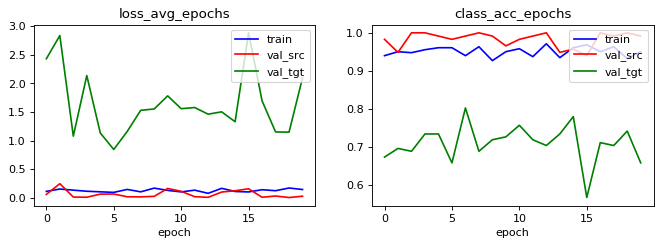

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (322, 3, 66)
val_data shape: (179, 3, 66)
Working on get_UPFall_loader...
train_data shape: (427, 3, 66)
val_data shape: (131, 3, 66)


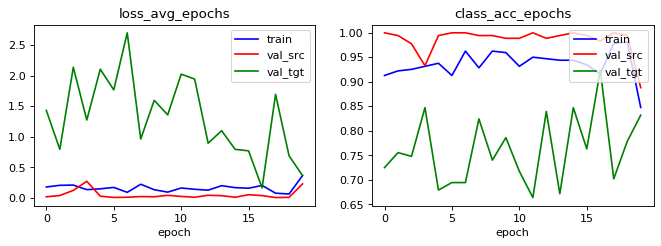

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (448, 3, 66)
val_data shape: (53, 3, 66)
Working on get_UPFall_loader...
train_data shape: (461, 3, 66)
val_data shape: (97, 3, 66)


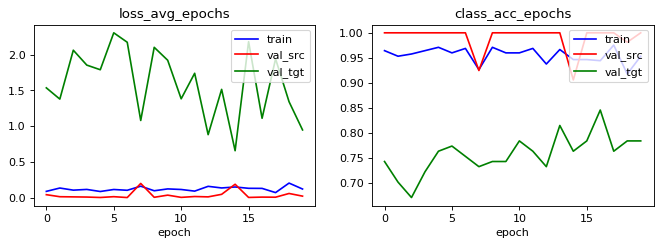

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (436, 3, 66)
val_data shape: (65, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (99, 3, 66)


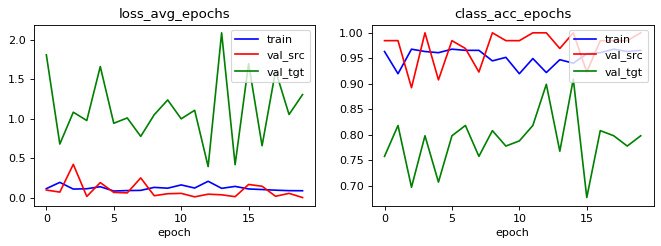

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (414, 3, 66)
val_data shape: (87, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (99, 3, 66)


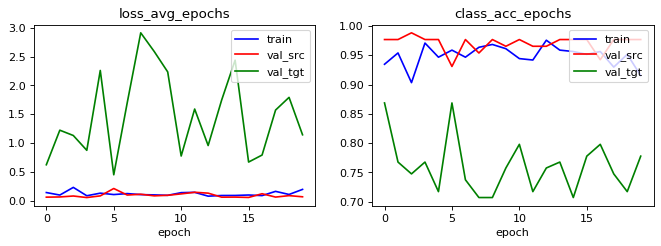

=================Exporting pytorch model=================
model saved successfully
===============Exporting model performance===============
show df_performance


,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.148744,0.950521,0.032001,0.991453,2.099219,0.659091
1,1.000000,0.365659,0.847826,0.230906,0.888268,0.366201,0.832061
2,2.000000,0.120258,0.953125,0.020785,1.000000,0.947098,0.783505
3,3.000000,0.088449,0.965596,0.002358,1.000000,1.305865,0.797980
4,4.000000,0.201012,0.915459,0.073028,0.977011,1.146597,0.777778
mean,2.000000,0.184825,0.926505,0.071816,0.971347,1.172996,0.770083
std,1.581139,0.109227,0.047765,0.092635,0.047383,0.628130,0.065533


src val loss: 0.0718±0.0926
src val acc: 0.9713±0.0474
tgt val loss: 1.1730±0.6281
tgt val acc: 0.7701±0.0655
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 501, 'classes_n': 2, 'model_name': 'DannModel', 'dataset_name': 'UMAFall', 'sensor_loc': 'waist', 'date': '2020/03/03 15:17:37', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}


In [15]:
# tasks_list = [('UMAFall_wrist', 'UPFall_wrist')]
tasks_list = [('UMAFall_waist', 'UPFall_belt')]

# optimal_training_params = {
#     'classes_n': 2,
#     'CV_n': 5,
#     'num_epochs': 3,
#     'channel_n': 32,
#     'batch_size': 1,
#     'learning_rate': 0.01}

training_params = {
    'classes_n': 2,
    'CV_n': 5,
    'num_epochs': 20,
    'channel_n': 2,
    'batch_size': 1,
    'learning_rate': 0.01,
    'dropout_p': 0.2}

for task_item in tasks_list:
  (src_name, tgt_name) = task_item

  inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz/'
  outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_archdesign_18hz/{}_{}/'.format(src_name, tgt_name)
  if not os.path.exists(outputdir):
      os.makedirs(outputdir)
  print('outputdir for stage2 output:', outputdir)
  
  source_outputs = ConvNet2Model_fitting(training_params, src_name, tgt_name, inputdir, outputdir+'source/')


In [0]:
source_outputs

((0.9947571981091534, 0.007255997887674031),
 (0.7562771116373461, 0.06769953859290327))

# Start CV training and validation in a big phat loop (to be deprecated)

In [0]:
# def model_fitting(CV_n, classes_n, sensor_loc, dataset_name, inputdir): 
#   # it's big phat loop i don't like it qq
#   df_performance = pd.DataFrame(columns=['i_CV','train_loss','train_acc','val_loss','val_acc'])

#   for i_CV in range(CV_n):
#     # 1. prepare dataset
#     train_inputdir = inputdir+'/CV{}/train'.format(i_CV)
#     val_inputdir = inputdir+'/CV{}/val'.format(i_CV)

#     train_data = data_loader('data', train_inputdir).transpose(2,1,0)
#     val_data = data_loader('data', val_inputdir).transpose(2,1,0)

#     train_labels = data_loader('labels', train_inputdir)
#     val_labels = data_loader('labels', val_inputdir)

#     train_i_sub = data_loader('i_sub', train_inputdir)
#     val_i_sub = data_loader('i_sub', val_inputdir)

#     print('train_data shape:', train_data.shape)
#     print('val_data shape:', val_data.shape)

#     train_size = train_labels.shape[0]
#     val_size = val_labels.shape[0]
#     input_dim = train_data.shape[2]

#     # convert labels from multi-class activities to binary (fall/ADL)
#     train_labels_binary = ((train_labels==10)|(train_labels==11)|(train_labels==12)).astype(int)
#     val_labels_binary = ((val_labels==10)|(val_labels==11)|(val_labels==12)).astype(int)

#     train_dataset = FallDataset(train_data, train_labels_binary)
#     val_dataset = FallDataset(val_data, val_labels_binary)
#     # data loader
#     batch_size = 4
#     learning_rate = 0.001

#     train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                               batch_size=batch_size, 
#                                               shuffle=True)

#     val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
#                                               batch_size=batch_size, 
#                                               shuffle=False)

#     # 2. prepare model
#     device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#     model = ConvNet(num_classes=classes_n, input_dim=input_dim).to(device).float()

#     # loss and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     # test model on a batch
#     try:
#       out = model(train_dataset.data[0:batch_size,:,:])
#       model_outdim = out.data.numpy().shape
#     except:
#       print('Warning: model cannot read input')

#     print('{} model architecture: '.format(model.__class__.__name__))
#     print(model)


#     # 3. fit the model
#     num_epochs = 10
#     total_step = len(train_loader)
#     for epoch in range(num_epochs):
#       total_train_loss = 0
#       train_TPTF = 0
#       for i, (data, labels) in enumerate(train_loader):
#         data = data.to(device)
#         labels = labels.to(device).long()

#         # Forward pass
#         outputs = model(data)
#         train_loss = criterion(outputs, labels)
#         total_train_loss += train_loss.data.numpy()
        
#         out_sigmoid = torch.sigmoid(outputs).data.numpy()
#         train_pred = np.argmax(out_sigmoid, 1)
#         train_TPTF += (train_pred==labels.data.numpy()).sum()
#         # train_pred = print(np.argmax(F.sigmoid(outputs))


#         # Backward and optimize
#         optimizer.zero_grad()
#         train_loss.backward()
#         optimizer.step()

#         # if (i+1) % 5 == 0:
#         #     print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.8f}' 
#         #             .format(epoch+1, num_epochs, i+1, total_step, train_loss.data.numpy()/labels.size()[0]))

#       total_val_loss = 0
#       val_TPTF = 0
#       for i, (data, labels) in enumerate(val_loader):
#         data = data.to(device)
#         labels = labels.to(device).long()
        
#         #Forward pass
#         val_outputs = model(data)
#         val_loss = criterion(val_outputs, labels)
#         total_val_loss += val_loss.data.numpy()

#         out_sigmoid = torch.sigmoid(val_outputs).data.numpy()
#         val_pred = np.argmax(out_sigmoid, 1)
#         val_TPTF += (val_pred==labels.data.numpy()).sum()
#         # print(val_TPTF, len(val_loader))
          
#       train_loss = total_train_loss/train_size
#       train_acc = train_TPTF/train_size
#       val_loss = total_val_loss/val_size
#       val_acc = val_TPTF/val_size


#       print('Epoch {}'.format(epoch+1))
#       print('Train Loss: {:.6f}, Train ACC: {:.6f}, Val loss = {:.6f}, Val ACC: {:.6f}'.
#             format(train_loss, train_acc, val_loss, val_acc))
    
#     # 4. store the performance of the model at the last epoch
#     df_performance.loc[i_CV] = [i_CV, train_loss, train_acc, val_loss, val_acc]

#   outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput/{}/{}/'.format(dataset_name, sensor_loc)
#   if not os.path.exists(outputdir):
#       os.makedirs(outputdir)
#   print('outputdir for stage2 output:', outputdir)

#   # 5. export model performance as df
#   export_perofmance(df_performance, CV_n, outputdir)

#   # 6. export notebook parameters as dict
#   # datetime object containing current date and time
#   now = datetime.now()
#   dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
#   samples_n = train_size + val_size

#   param_dict = {
#       'CV_n': CV_n,
#       'samples_n': samples_n,
#       'classes_n': classes_n,
#       'model_name': model.__class__.__name__,
#       'dataset_name': dataset_name,
#       'sensor_loc': sensor_loc,
#       'date': dt_string,
#       'batch_size': batch_size,
#       'input_dim': (batch_size, train_dataset.data.size()[1], train_dataset.data.size()[2]),
#       'output_dim': train_dataset.labels[0:batch_size].data.numpy().shape,
#       'label_dim': CV_n,
#   }
#   print(param_dict)

#   with open(outputdir+'notebook_param.json', 'w') as fp:
#     json.dump(param_dict, fp)

#   export_model(model, classes_n, input_dim, device, outputdir)

In [0]:
# datasets_sensor_dict = {
#     'UMAFall': ['waist', 'wrist', 'leg', 'chest', 'ankle'],
#     'UPFall': ['wrist', 'rightpocket', 'neck', 'belt', 'ankle']
# }

In [0]:
# inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed/{}/{}/'.format(dataset_name, sensor_loc)
# classes_n = 2
# CV_n = 5

# for key in datasets_sensor_dict.keys():
#   dataset_name = key
#   for sensor_loc in datasets_sensor_dict[dataset_name]:
#     model_fitting(CV_n, classes_n, sensor_loc, dataset_name, inputdir)